## **Introduction**
This project is inspired by the close relationship between the Chilean Peso (CLP) and the global price of copper. Chile is the world's largest producer of copper, and its economy is heavily reliant on copper exports. Historically, fluctuations in the price of copper have had a significant impact on the Chilean Peso's value against major currencies like the USD. Traders can leverage this correlation to create an arbitrage strategy that exploits price divergences between copper and the CLP.

The aim of this project is to explore a quantitative trading strategy using copper prices as a key indicator to forecast movements in the CLP/USD exchange rate. By applying regression models, confidence intervals, and momentum-based trading signals, we aim to identify periods where the Peso is over- or undervalued relative to the copper price, generating buy or sell signals.

Below is a full implementation of a quantitative trading algorithm that identifies arbitrage opportunities between the price of copper and the Chilean Peso.

#### **LIBRARIES AND DATA SETUP**

In [25]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Load the two datasets
copper_data = pd.read_csv('/content/Copper Futures Historical Data.csv')
clp_data = pd.read_csv('/content/USD_CLP Historical Data.csv')

# Convert the 'Date' columns to datetime format
copper_data['Date'] = pd.to_datetime(copper_data['Date'])
clp_data['Date'] = pd.to_datetime(clp_data['Date'])

# Set the 'Date' column as the index for both datasets
copper_data.set_index('Date', inplace=True)
clp_data.set_index('Date', inplace=True)

# Merge the two datasets on the 'Date' column
data = pd.merge(copper_data[['Price']], clp_data[['Price']], left_index=True, right_index=True, suffixes=('_copper', '_clp'))

# Rename columns
data.rename(columns={'Price_copper': 'copper_price', 'Price_clp': 'clp_usd'}, inplace=True)


### **Exploratory Analysis**

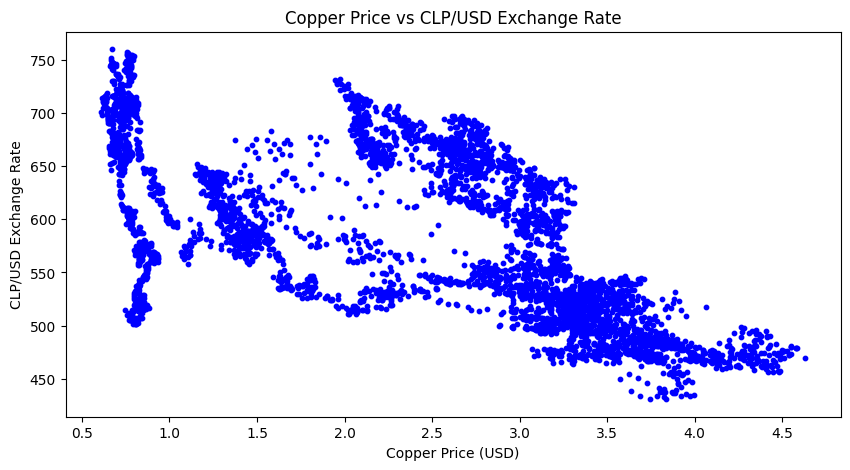

Correlation between copper and CLP/USD: -0.6330286118929588


In [26]:
# Scatter plot to visualize the relationship between copper and CLP/USD
plt.figure(figsize=(10, 5))
plt.scatter(data['copper_price'], data['clp_usd'], s=10, color='blue')
plt.title('Copper Price vs CLP/USD Exchange Rate')
plt.xlabel('Copper Price (USD)')
plt.ylabel('CLP/USD Exchange Rate')
plt.show()

# Correlation coefficient
correlation = np.corrcoef(data['copper_price'], data['clp_usd'])[0, 1]
print(f"Correlation between copper and CLP/USD: {correlation}")


###**Signal Generation and Trading Strategy**
The strategy identifies trading signals by running a regression model on the relationship between copper prices and CLP/USD. A two-sigma confidence interval is used to generate buy/sell signals based on the residuals from the regression.

In [42]:
# Function to generate signals using regression on copper and CLP/USD
def generate_signals(data, train_size=100):
    df = data.copy()

    # Train regression model on copper and CLP/USD
    X = sm.add_constant(df['copper_price'][:train_size])
    Y = df['clp_usd'][:train_size]
    model = sm.OLS(Y, X).fit()

    # Calculate fitted values and residuals
    df['fitted'] = model.predict(sm.add_constant(df['copper_price']))
    df['residuals'] = df['clp_usd'] - df['fitted']

    # Calculate standard deviation of residuals
    sigma = np.std(df['residuals'][:train_size])

    # Generate signals based on residuals exceeding ±2 sigma
    df['upper'] = df['fitted'] + 2 * sigma
    df['lower'] = df['fitted'] - 2 * sigma
    df['signals'] = np.where(df['clp_usd'] > df['upper'], -1, np.where(df['clp_usd'] < df['lower'], 1, 0))

    # Ensure the first signal is recorded when thresholds are crossed
    df['signals'] = df['signals'].diff().fillna(0)

    return df

# Generate trading signals
signals = generate_signals(data)

### **Portfolio Management**

In [43]:
# Function to simulate portfolio performance
def simulate_portfolio(signals, initial_capital=10000):
    df = signals.copy()

    positions = initial_capital // max(df['clp_usd'])  # Correctly calculate the number of positions
    df['holdings'] = df['signals'].cumsum() * df['clp_usd'] * positions
    df['cash'] = initial_capital - (df['signals'] * df['clp_usd'] * positions).cumsum()

    # Ensure the cash balance never goes negative at the start
    df['portfolio_value'] = df['holdings'] + df['cash']
    df.loc[df['portfolio_value'] < 0, 'portfolio_value'] = initial_capital  # Safety net

    return df

# Simulate portfolio performance
portfolio = simulate_portfolio(signals)


### **Visualization**
Finally, I can visualize the performance of the trading strategy.

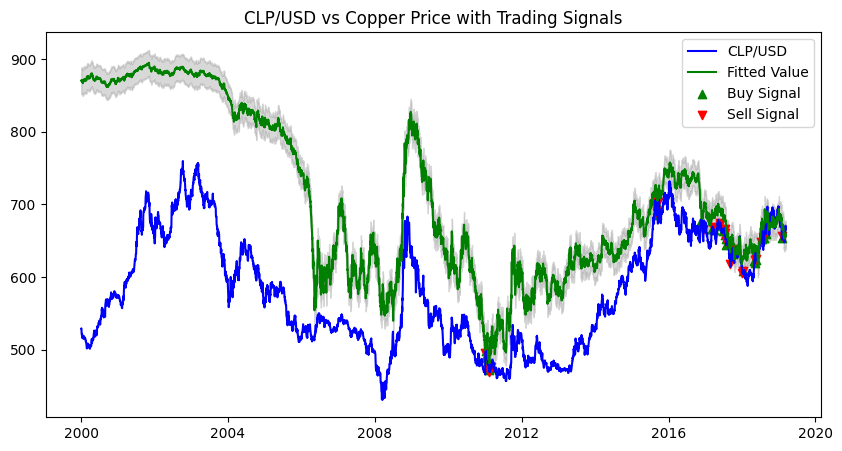

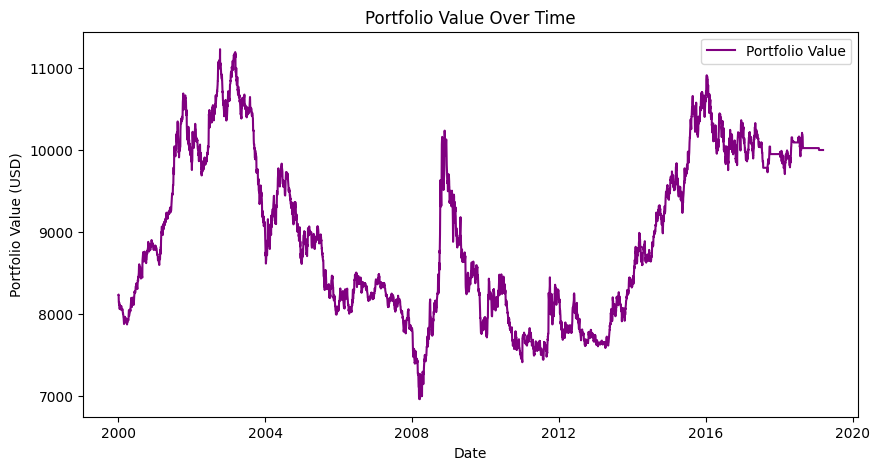

In [44]:
# Plotting signals and portfolio performance
def plot_signals(signals):
    plt.figure(figsize=(10, 5))
    plt.plot(signals.index, signals['clp_usd'], label='CLP/USD', color='blue')
    plt.plot(signals.index, signals['fitted'], label='Fitted Value', color='green')
    plt.fill_between(signals.index, signals['upper'], signals['lower'], color='gray', alpha=0.3)

    buy_signals = signals[signals['signals'] == 1]
    sell_signals = signals[signals['signals'] == -1]

    plt.scatter(buy_signals.index, buy_signals['clp_usd'], marker='^', color='green', label='Buy Signal', alpha=1)
    plt.scatter(sell_signals.index, sell_signals['clp_usd'], marker='v', color='red', label='Sell Signal', alpha=1)

    plt.title('CLP/USD vs Copper Price with Trading Signals')
    plt.legend()
    plt.show()

def plot_portfolio(portfolio):
    plt.figure(figsize=(10, 5))
    plt.plot(portfolio.index, portfolio['portfolio_value'], label='Portfolio Value', color='purple')
    plt.title('Portfolio Value Over Time')
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value (USD)')
    plt.legend()
    plt.show()

# Plot the signals and portfolio performance
plot_signals(signals)
plot_portfolio(portfolio)